In [37]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# import data
df = pd.read_csv('train.csv')
te_df = pd.read_csv('test.csv')
# df.head(3)

In [38]:
# drop id
df.drop(columns=['id'], inplace=True)
te_df.drop(columns=['id'], inplace=True)

# drop target
target = 'loan_status'
loan_status = df[target].copy()
df.drop(columns=[target], inplace=True)

# 檢查缺失值
missing_values = df.isnull().sum()
print("Missing values in each column:")
print(missing_values[missing_values > 0] if missing_values.any() else "No missing values found.")

Missing values in each column:
No missing values found.


In [41]:
# 列出待處理的features類型
categorical_columns = df.select_dtypes(include=['object', 'category']).columns
for col in categorical_columns:
    unique_values = df[col].unique()
    print(f"待處理欄位: {col}, 類別值: {unique_values}")

numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
print("\n待處理的數值型特徵欄位名稱:", numeric_columns.tolist())

待處理欄位: person_home_ownership, 類別值: ['RENT' 'OWN' 'MORTGAGE' 'OTHER']
待處理欄位: loan_intent, 類別值: ['EDUCATION' 'MEDICAL' 'PERSONAL' 'VENTURE' 'DEBTCONSOLIDATION'
 'HOMEIMPROVEMENT']
待處理欄位: loan_grade, 類別值: ['B' 'C' 'A' 'D' 'E' 'F' 'G']
待處理欄位: cb_person_default_on_file, 類別值: ['N' 'Y']

待處理的數值型特徵欄位名稱: ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']


Data Visualization

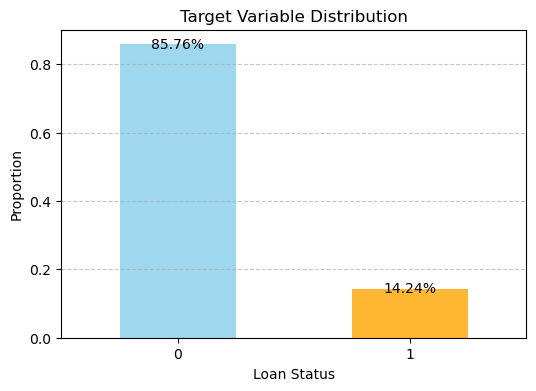

In [39]:
target_proportions = loan_status.value_counts(normalize=True)

# 繪製目標變數的分佈圖
plt.figure(figsize=(6, 4))
bars = target_proportions.plot(kind='bar', color=['skyblue', 'orange'], alpha=0.8)

# 標註比例
for bar in bars.patches:
    proportion = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, proportion - 0.02, 
             f'{proportion:.2%}', ha='center', va='bottom', fontsize=10, color='black')

plt.title('Target Variable Distribution')
plt.xlabel('Loan Status')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

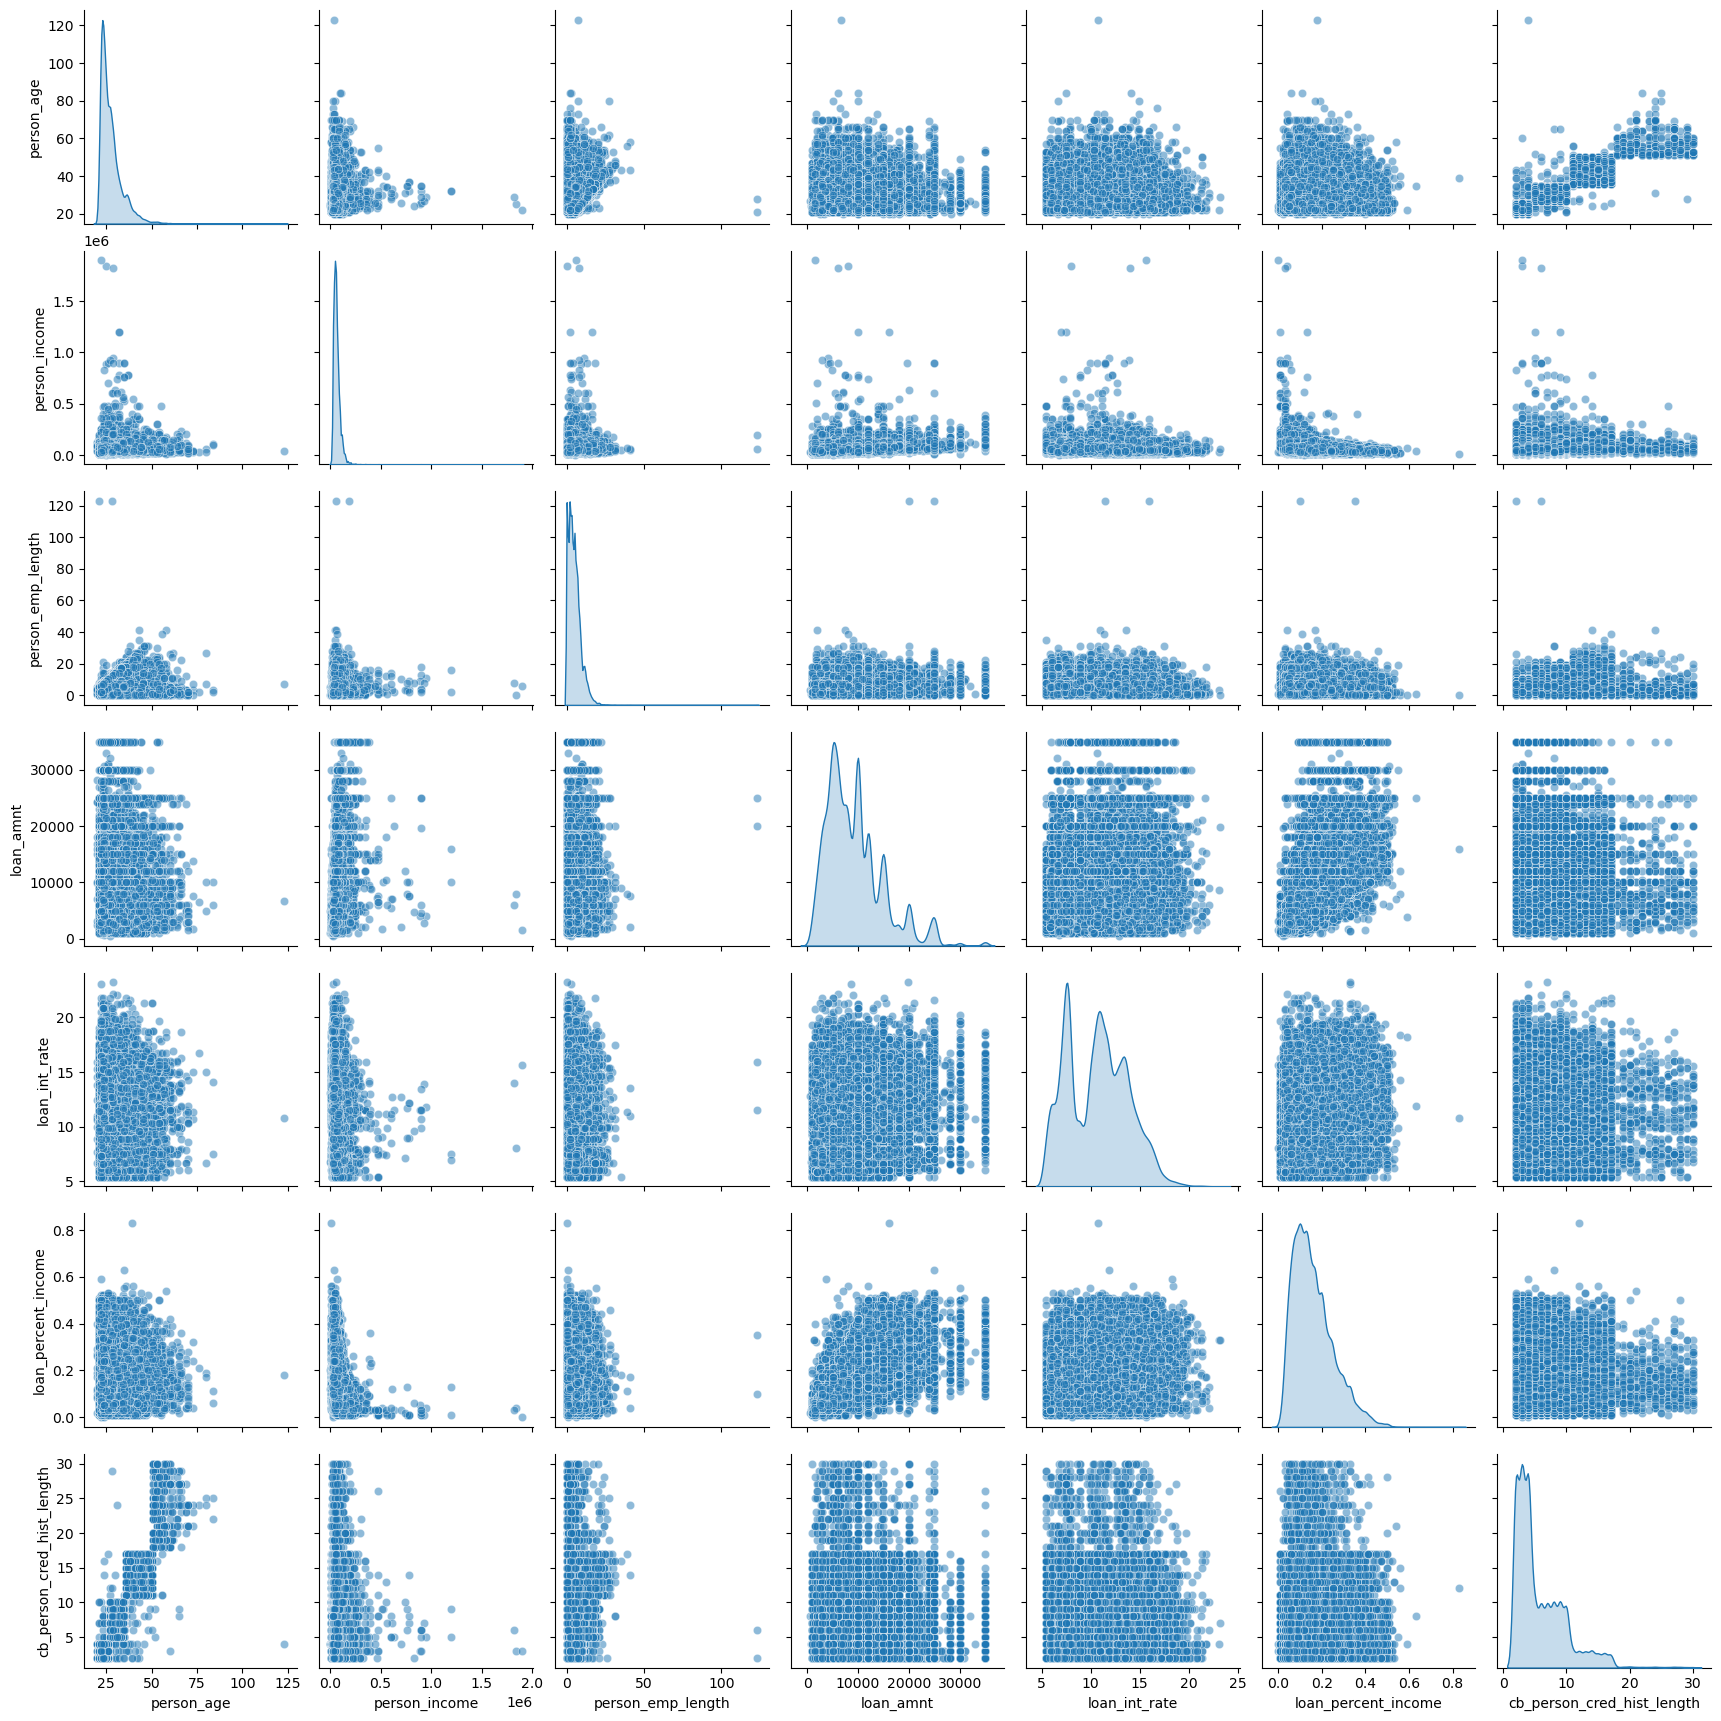

In [40]:
import seaborn as sns

# 繪製散點圖矩陣
features = [col for col in df.columns]
sns.pairplot(df[features], diag_kind='kde', plot_kws={'alpha': 0.5})
plt.show()

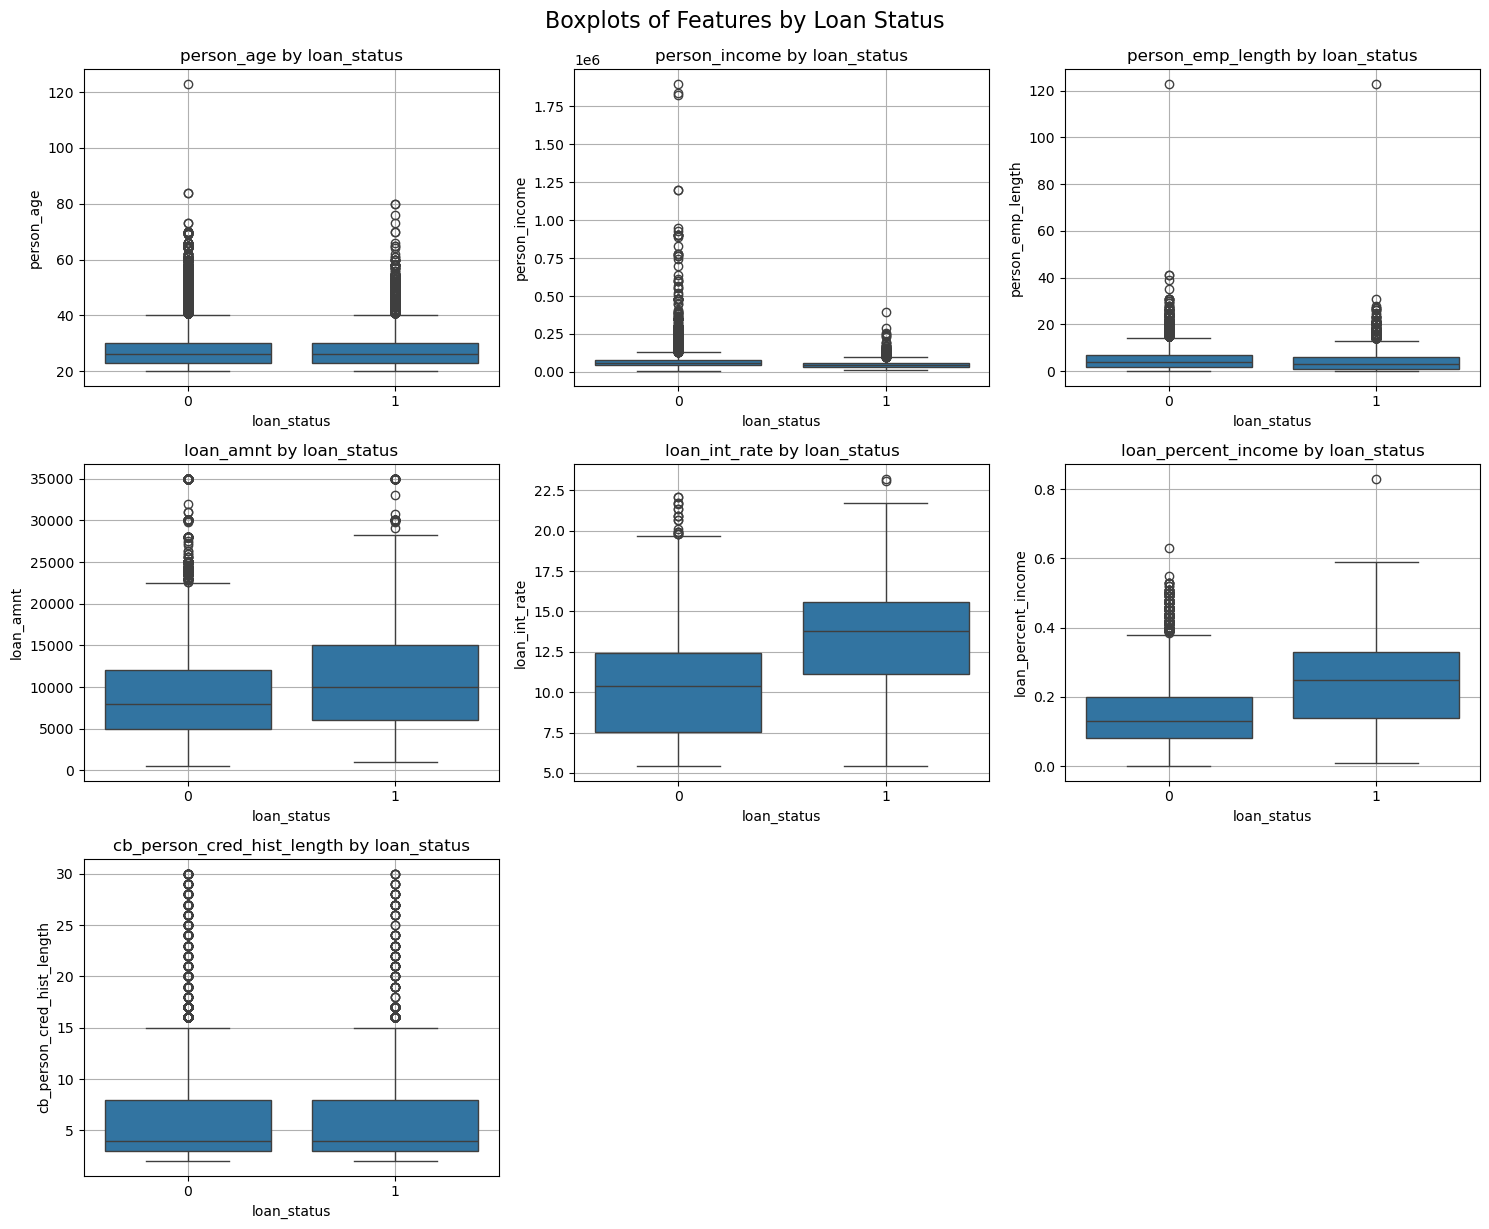

In [43]:
# 選取數值型欄位
n = len(numeric_columns)
cols = 3
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
axes = axes.flatten()

for i, feature in enumerate(numeric_columns):
    sns.boxplot(x=loan_status, y=feature, data=df, ax=axes[i])
    axes[i].set_title(f'{feature} by loan_status')
    axes[i].grid(True)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle('Boxplots of Features by Loan Status', fontsize=16, y=1.02)
plt.show()

Data Preprocessing

In [44]:
# 偏態處理
from scipy.stats import skew

def handle_skewness(df, columns):
    for col in columns:
        skewness = skew(df[col].dropna())  # 計算偏態
        print(f"{col} 偏態: {skewness:.2f}")
        
        if abs(skewness) > 1:
            # print(f"處理 {col} 的偏態")
            df[col] = np.log1p(df[col])

handle_skewness(df, numeric_columns)
handle_skewness(te_df, numeric_columns)

person_age 偏態: 1.97
person_income 偏態: 10.46
person_emp_length 偏態: 2.05
loan_amnt 偏態: 1.19
loan_int_rate 偏態: 0.20
loan_percent_income 偏態: 0.92
cb_person_cred_hist_length 偏態: 1.62
person_age 偏態: 1.94
person_income 偏態: 10.45
person_emp_length 偏態: 1.16
loan_amnt 偏態: 1.20
loan_int_rate 偏態: 0.19
loan_percent_income 偏態: 0.94
cb_person_cred_hist_length 偏態: 1.65


In [46]:
def handle_outliers(df, column, threshold=0.05):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # 計算離群值比例
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    ratio = len(outliers) / len(df)

    if ratio > threshold:
        df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
        status = "處理"
    else:
        status = "略過"

    print(f"{column}: 離群值比例 {ratio:.2%}，已{status}")

for col in numeric_columns:
    handle_outliers(df, col)
    handle_outliers(te_df, col)

person_age: 離群值比例 2.00%，已略過
person_age: 離群值比例 2.05%，已略過
person_income: 離群值比例 1.10%，已略過
person_income: 離群值比例 1.11%，已略過
person_emp_length: 離群值比例 0.01%，已略過
person_emp_length: 離群值比例 0.00%，已略過
loan_amnt: 離群值比例 1.02%，已略過
loan_amnt: 離群值比例 0.97%，已略過
loan_int_rate: 離群值比例 0.06%，已略過
loan_int_rate: 離群值比例 0.03%，已略過
loan_percent_income: 離群值比例 2.06%，已略過
loan_percent_income: 離群值比例 2.07%，已略過
cb_person_cred_hist_length: 離群值比例 0.05%，已略過
cb_person_cred_hist_length: 離群值比例 0.06%，已略過


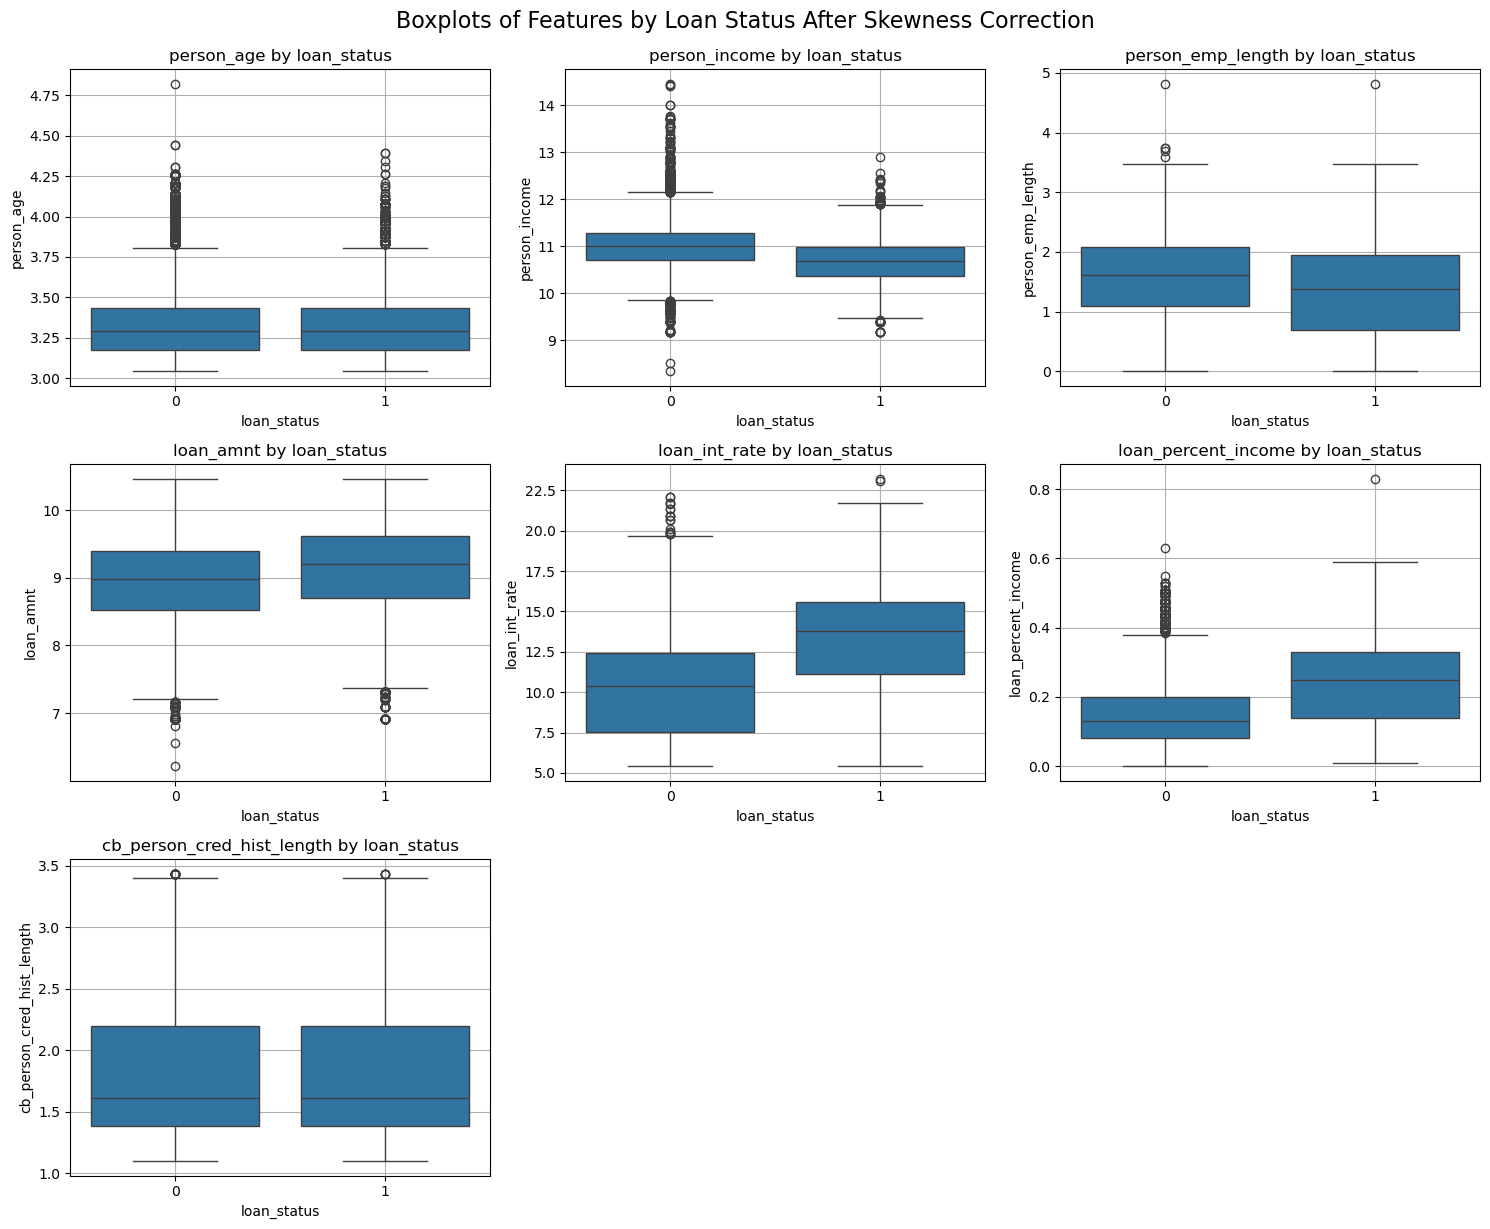

In [47]:
# 可以觀察出偏態處理後已不需要做離群值處理
n = len(numeric_columns)
cols = 3
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
axes = axes.flatten()

for i, feature in enumerate(numeric_columns):
    sns.boxplot(x=loan_status, y=feature, data=df, ax=axes[i])
    axes[i].set_title(f'{feature} by loan_status')
    axes[i].grid(True)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle('Boxplots of Features by Loan Status After Skewness Correction', fontsize=16, y=1.02)
plt.show()

In [48]:
# 數值型資料標準化
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

df[numeric_columns] = scaler.fit_transform(df[numeric_columns])
te_df[numeric_columns] = scaler.transform(te_df[numeric_columns])

In [49]:
# 處理類別型資料
one_hot_cols = ['person_home_ownership', 'loan_intent']
ordinal_cols = {'loan_grade': ['A', 'B', 'C', 'D', 'E', 'F', 'G']}  # 具有順序
binary_cols = ['cb_person_default_on_file']  # 類別僅有N/Y

# One-Hot Encoding
for col in one_hot_cols:
    print(f"One-Hot Encoding: {col}")
    dummies = pd.get_dummies(df[col], prefix=col)
    df = pd.concat([df, dummies], axis=1)
    df.drop(columns=[col], inplace=True)
    # 同步處理 te_df
    tr_dummies = pd.get_dummies(te_df[col], prefix=col)
    te_df = pd.concat([te_df, tr_dummies], axis=1)
    te_df.drop(columns=[col], inplace=True)
    

# Ordinal Encoding
for col, order in ordinal_cols.items():
    print(f"Ordinal Encoding: {col}")
    df[col] = df[col].astype(pd.CategoricalDtype(categories=order, ordered=True)).cat.codes
    te_df[col] = te_df[col].astype(pd.CategoricalDtype(categories=order, ordered=True)).cat.codes

# Label Encoding
for col in binary_cols:
    print(f"Label Encoding (binary): {col}")
    df[col] = df[col].map({'Y': 1, 'N': 0})
    te_df[col] = te_df[col].map({'Y': 1, 'N': 0})

One-Hot Encoding: person_home_ownership
One-Hot Encoding: loan_intent
Ordinal Encoding: loan_grade
Label Encoding (binary): cb_person_default_on_file


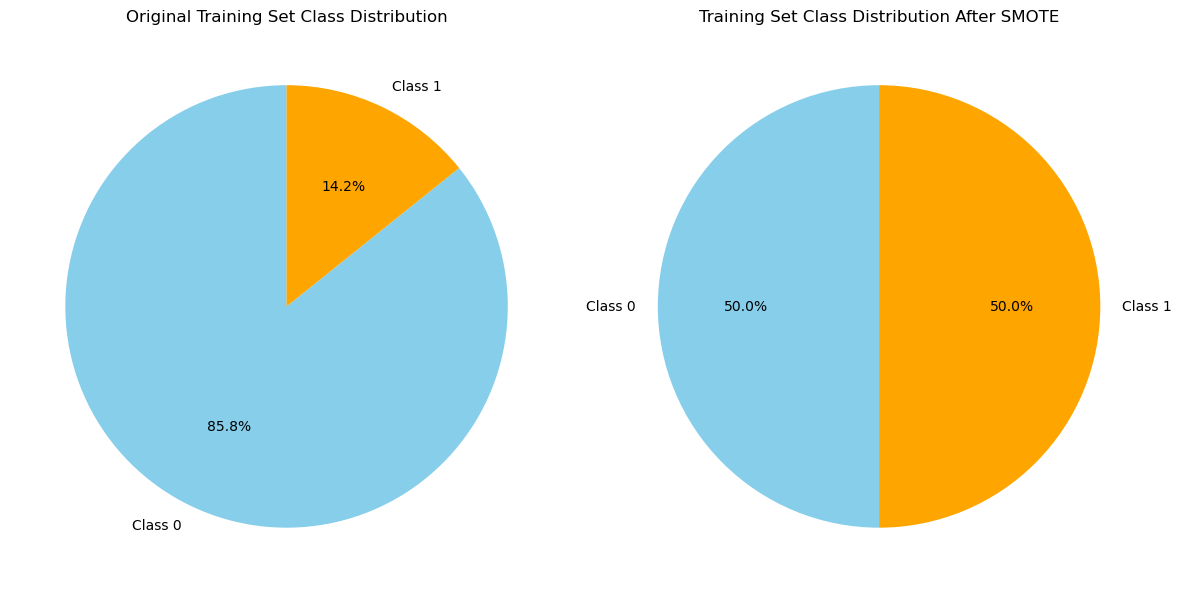

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# 切分資料集
X = df
y = loan_status
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# smote, over sampling
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# 繪製兩張圓餅圖進行比對
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

y_train.value_counts().plot.pie(
    autopct='%1.1f%%', startangle=90, ax=axes[0], labels=['Class 0', 'Class 1'], colors=['skyblue', 'orange']
)
axes[0].set_title("Original Training Set Class Distribution")
axes[0].set_ylabel('')

# After SMOTE
y_train_resampled.value_counts().plot.pie(
    autopct='%1.1f%%', startangle=90, ax=axes[1], labels=['Class 0', 'Class 1'], colors=['skyblue', 'orange']
)
axes[1].set_title("Training Set Class Distribution After SMOTE")
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

Model Prediction

In [ ]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=500,  # 增加樹的數量
    max_depth=10,  # 限制樹的深度
    min_samples_split=5,  # 每個節點至少包含的樣本數
    min_samples_leaf=2,  # 每個葉子節點至少包含的樣本數
    class_weight='balanced',  # 處理類別不平衡
    random_state=42
)

# train
rf_model.fit(X_train_resampled, y_train_resampled)

# predict
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# evaluate
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nROC AUC Score:")
print(roc_auc_score(y_test, y_pred_proba))

Confusion Matrix:
[[9692  367]
 [ 393 1277]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     10059
           1       0.78      0.76      0.77      1670

    accuracy                           0.94     11729
   macro avg       0.87      0.86      0.87     11729
weighted avg       0.93      0.94      0.93     11729


ROC AUC Score:
0.9348829927380551


In [59]:
# XGBoost
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=500,  # 增加樹的數量
    learning_rate=0.05,  # 降低學習率
    max_depth=6,  # 限制樹的深度
    subsample=0.8,  # 隨機抽樣比例
    colsample_bytree=0.8,  # 每棵樹使用的特徵比例
    scale_pos_weight=1,  # 處理類別不平衡
    random_state=42,
    eval_metric='auc'  # 使用 AUC 作為評估指標
)

# train
xgb_model.fit(X_train_resampled, y_train_resampled)

# predict
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

# evaluate
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nROC AUC Score:")
print(roc_auc_score(y_test, y_pred_proba))

Confusion Matrix:
[[9936  123]
 [ 442 1228]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     10059
           1       0.91      0.74      0.81      1670

    accuracy                           0.95     11729
   macro avg       0.93      0.86      0.89     11729
weighted avg       0.95      0.95      0.95     11729


ROC AUC Score:
0.9531268509804132


In [60]:
from catboost import CatBoostClassifier

catboost_model = CatBoostClassifier(
    iterations=1000,  # 增加迭代次數
    learning_rate=0.05,  # 降低學習率
    depth=8,  # 限制樹的深度
    l2_leaf_reg=3,  # 增加 L2 正則化
    eval_metric='AUC',  # 使用 AUC 作為評估指標
    random_seed=42,
    class_weights=[1, 2],  # 處理類別不平衡
    verbose=100
)

# train
catboost_model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50)

# predict
y_pred = catboost_model.predict(X_test)
y_pred_proba = catboost_model.predict_proba(X_test)[:, 1]

# evaluate
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nROC AUC Score:")
print(roc_auc_score(y_test, y_pred_proba))

0:	test: 0.9062600	best: 0.9062600 (0)	total: 50.9ms	remaining: 50.9s
100:	test: 0.9405926	best: 0.9405926 (100)	total: 379ms	remaining: 3.37s
200:	test: 0.9475421	best: 0.9475421 (200)	total: 700ms	remaining: 2.78s
300:	test: 0.9524860	best: 0.9524860 (300)	total: 1.02s	remaining: 2.38s
400:	test: 0.9544588	best: 0.9544588 (400)	total: 1.35s	remaining: 2.02s
500:	test: 0.9554449	best: 0.9554632 (491)	total: 1.67s	remaining: 1.67s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9554925937
bestIteration = 508

Shrink model to first 509 iterations.
Confusion Matrix:
[[9905  154]
 [ 421 1249]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     10059
           1       0.89      0.75      0.81      1670

    accuracy                           0.95     11729
   macro avg       0.92      0.87      0.89     11729
weighted avg       0.95      0.95      0.95     11729


ROC AUC Score:
0.9554925936971

In [61]:
import datetime

timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M")

test_pred_proba = xgb_model.predict_proba(te_df)[:, 1]

# 建立提交檔案
submission = pd.DataFrame({
    'id': pd.read_csv('test.csv')['id'],  # 從原始 test.csv 中讀取 'id' 欄位
    'loan_status': test_pred_proba  # 預測的機率
})

submission_filename = f"submission_{timestamp}.csv"
submission.to_csv(submission_filename, index=False)

print(f"Submission file saved as '{submission_filename}'")

Submission file saved as 'submission_20250507_2204.csv'
